# Assignment: Expectation-Maximization algorithm for Gaussian Mixture Models

# Gaussian Mixture Models 

A Gaussian Mixture Model represents a distribution that is composed of several Gaussian distributions, each identified by $k \in {1,…, K}$, where $K$ is the number of clusters of our dataset.

The Gaussian distribution of a $d$-dimensional vector $X$ is characterized by its mean $\mu$ and its covariance matrix $\Sigma$. The random vector $X$ has a density that we will denote $\mathcal{N}(x|\mu, \Sigma)$, if and only if its covariance matrix is invertible, in which case:

$$\mathcal{N}(x|\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1} (x-\mu)), $$
where $|\Sigma|$ is the determinant of $\Sigma$.

Now let's consider the $k$ Gaussians in the mixture with respective parameters parameters $(\mu_1, \Sigma_1),...,(\mu_k, \Sigma_k)$. Let $\pi_1,...,\pi_k$ be any probability distribution on ${1,...,k}$. Let $X \sim \mathcal{N}(\mu_Z, \Sigma_Z)$ with $Z \sim \pi$. The vector $X$ has density:

$$p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x|\mu_k, \Sigma_k).$$


### Maximum likelihood estimators

Let us assume we want to estimate the parameters $\theta = (\mu, \Sigma)$ based on $n$ i.i.d samples $x_1,...,x_n$ of the Gaussian Mixture Model. By denoting $x = (x_1,...,x_n)$, we get the likelihood:

$$\cal{L} (x|\theta) = \prod_{i=1}^{n} p(x_i) = \prod_{i=1}^{n} \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k),$$
and the log-likelihood:

$$\ell(x|\theta) = log \cal{L} (x|\theta) = \sum_{i=1}^{n} log p(x_i) = \sum_{i=1}^{n} log \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k).$$

The maximum likelihood estimator is given by $\theta^* = argmax_{\theta} \ell(x|\theta).$ This problem is hard to solve in practice, as $\theta \mapsto -\ell(x|\theta)$ is not generally convex.

### Expectation-Maximization 

The Expectation-Maximization ($EM$) algorithm is an iterative method to find a local maximum of likelihood devoted to statistical models with latent variables. The $EM$ is based on the observation that the previous problem would be easy to solve if we had latent variable $z=(z_1,...,z_n)$ used to generate the samples $(x_1,...,x_n)$.

Let $z=(z_1,...,z_n)$ be the vector of latent variables. The Gaussian Mixture Model can be written as the marginal distribution of the joint distribution :

$$p(x,z) = p(z)p(x|z)$$

with $$p(z) = \prod_{i=1}^{n} \pi_{z_i} \quad \textrm{and} \quad p(x|z)= \prod_{i=1}^{n} \mathcal{N}(xi|\mu_{z_i}, \Sigma_{z_i}).$$

Given the latent variable, the log-likelihood can be written as:

$$\ell(x,z|\theta) = \sum_{i=1}^{n} log \pi_{z_i} + \sum_{i=1}^{n} log \mathcal{N}(x_i|\mu_{z_i}, \Sigma_{z_i}).$$

If we knew $z_i$ for each $x_i$, each set of $(\mu_{z_i}, \Sigma_{z_i})$ could be estimated separately easily. 


The idea behind the $EM$ algorithm is to alternate between two steps to optimize the likelihood of the model: 
1. **E-step:** Compute the expectation of the likelihood of the model. In particular, compute the posterior probability that each Gaussian generates each data point.
2. **M-step:** Assuming that the data really was generated that way, update the parameters of each Gaussian to maximize the expectation and the probability that it would generate the data it is currently associated to.

# Implementing the EM algorithm

### Data preparation

In [1]:
library(pgmm)
library(mclust)
data(wine)

Package 'mclust' version 5.4.5
Type 'citation("mclust")' for citing this R package in publications.



Let us first load the data and have a look at it.

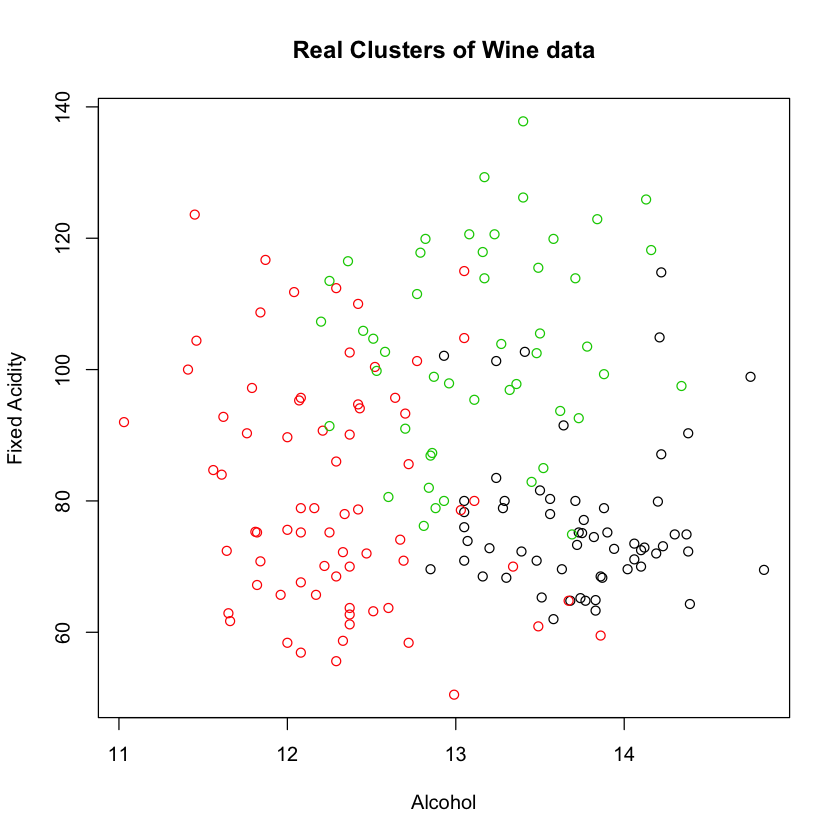

In [2]:
X = as.matrix(wine[,c(2,4)])
y = wine[,1]
plot(X,col=y, main="Real Clusters of Wine data")

### E-step 

First let us derive the expectation of the complete likelihood:

$$\begin{align}
\mathbb{E}[\ell(x,z|\theta)] &= \sum_z p(z|x) \ell(x,z|\theta) \\
&= \sum_{k=1}^{K} \sum_{i=1}^{n} p(z_k|x_i) log \pi_k\mathcal{N}(x_i|\mu_k, \Sigma_k)
\end{align}$$

We need now to compute the probability that sample $i$ comes from distribution $k$. The conditionnal distribution of the latent variable given the data follows from Bayes rule, indeed :

$$\begin{align}
p(z|x) & = \frac{p(x|z)p(z)}{p(x)} \\
&= \frac{p(x,z)}{p(x)} \\
&= \frac{\prod_{k=1}^{K} \pi_{k}\mathcal{N}(x|\mu_{k}, \Sigma_{k})}{p(x)}
\end{align}$$

In particular, the probability that sample $i$ comes from distribution $k$ is given by:

$$ \tau_{ik} = p(z_k|x_i) = \frac{\pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)}{\sum_{j=1}^{K}\pi_j\mathcal{N}(x_i|\mu_j, \Sigma_j)}.$$

In reality, $\tau_{ij}$ is the only quantity that needs to be computed at each iteration of the $EM$ algorithm. 

To increase accuracy and avoid underflow and overflow problems when very small or very large numbers are represented directly, the $LogSumExp$ $(LSE)$ function – a smooth approximation to the maximum function – can be used. It is defined as the logarithm of the sum of the exponentials of the arguments:

$$LSE(x_1,...,x_n) = log(exp(x_1)+...+exp(x_n))$$

Similar to multiplication operations in linear-scale becoming simple additions in log-scale, an addition operation in linear-scale becomes the LSE in log-scale. Using this trick, we can rewrite:

$$\tau_{ij} = exp(s_k - LSE(s_k))$$

where $s_k = log \pi_k + log \mathcal{N}(x|\mu_k, \Sigma_k)$.

In [3]:
log_gaussian_density <- function (x, mean, sigma) {
  distval <- mahalanobis(x, center = mean, cov = sigma)
  logdet <- determinant(sigma,logarithm = TRUE)$modulus
  logretval <- -(ncol(x) * log(2 * pi) + logdet + distval)/2
  return(logretval)
}

In [4]:
logsumexp <- function (x) {
  y = max(x)
  y + log(sum(exp(x - y)))
}

In [5]:
expectation_step<- function(X, n, K, pis, mus, sigmas){
    sk = matrix(NA, nrow = n, ncol = K)
    
    for (k in 1:K){
      sk[,k] = log(pis[k]) + log_gaussian_density(X, mus[k,],sigmas[[k]])
      }
    s = apply(sk, 1, logsumexp)
    T = exp(sk - s)
    l = sum(s)

    list(T, l)
}

### M-step

We now need to update the parameters of each Gaussian distribution to maximize the expectation. In reality, $\mathbb{E}[\ell(x,z|\theta)]$ is at its maximum when:

$$\pi_k = \frac{n_k}{n}, \quad \mu_k = \frac{1}{n_k}\sum_{i=1}^{n}(\tau_{ik}x_i), \quad \Sigma_k = \frac{1}{n_k}\sum_{i=1}^{n}\tau_{ik}(x_i - \mu_k)(x_i - \mu_k)^T, \quad \textrm{and} \quad n_k = \sum_{i=1}^{n} \tau_{ik}.$$

In [6]:
maximization_step <-function(X, n, K, pis, mus, sigmas, T){
    
    for (k in 1:K){
        pis[k] = sum(T[,k])/n
        mus[k,] = (T[,k] %*% X)/ sum(T[,k])
        x_scale = scale(X, center=mus[k,], scale = FALSE)
        sigmas[[k]] = (t(T[,k] * x_scale) %*% x_scale) / sum(T[,k])
    }
    
    list(pis, mus, sigmas)
}

### Initialization

We can consider two different initializations for our algorithm. 

A first method is random initialization. $EM$ being very sensitive to initialization, this method might require to run multiple $EMs$ and select the model with the highest likelihood (i.e. highest local maximum). 

In [7]:
random_init <- function(X, n, K, d){
    
    mus = matrix(nrow=K, ncol=d)
    sigmas = list()
    pis = c()
    
    random_clustering = sample(1:K, n , replace=TRUE)
    
    for (k in 1:K){
        mus[k,] = colMeans(X[random_clustering == k,])
        sigmas[[k]] = cov(X[random_clustering==k,])
        pis[k] = mean(random_clustering==k)
    }
    
    list(pis, mus, sigmas)
}

Another possibility is the initialization using the result of $k$-means clustering. The advantage of this method might be a faster convergence of the algorithm.

In [8]:
kmeans_init <- function(X, n, K, d){
    
    mus = matrix(nrow=K, ncol=d)
    sigmas = list()
    pis = c()
    
    km = kmeans(X, centers=K)
    km_clustering = km$cluster
    
    for (k in 1:K){
        mus[k,] = colMeans(X[km_clustering == k,])
        sigmas[[k]] = cov(X[km_clustering==k,])
        pis[k] = mean(km_clustering==k)
    }
    
    list(pis, mus, sigmas)
}

### The EM algorithm

We can now implement the algorithm, alternating between E-steps and M-steps. We can compute the log-likelihood of the data at each step to verify our model has converged. 

Recall the log-likelihood is given by:

$$\begin{align}
\ell(x|\theta) &= \sum_{i=1}^{n} log p(x_i) \\
&= \sum_{i=1}^{n} log \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)\\
&= \sum_{i=1}^{n} LSE(s_k)
\end{align}$$

where $s_k = log \pi_k + log \mathcal{N}(x|\mu_k, \Sigma_k)$.

In [9]:
multivariate_EM <- function(X, K, init= 'kmeans' ,maxit = 500){
    n=dim(X)[1]
    d=dim(X)[2]
    loglik = c()
    
    #Initialization of Theta
    if (init == 'random'){
        r_init = random_init(X, n, K, d)
        pis = r_init[[1]]; mus = r_init[[2]]; sigmas = r_init[[3]]
    } else if (init == 'kmeans') {
        km_init = kmeans_init(X, n, K, d)
        pis = km_init[[1]]; mus = km_init[[2]]; sigmas = km_init[[3]]  
    }
    
    #The loop
    for(it in 1:maxit){
        #Expectation step
        e = expectation_step(X, n, K, pis, mus, sigmas)
        T = e[[1]]; l = e[[2]]; loglik = append(loglik, l)
        
        #Maximization step
        m = maximization_step(X, n, K, pis, mus, sigmas, T)
        pis = m[[1]]; mus = m[[2]]; sigmas = m[[3]]
    }
    list(pis, mus, sigmas, T, loglik, l)
}

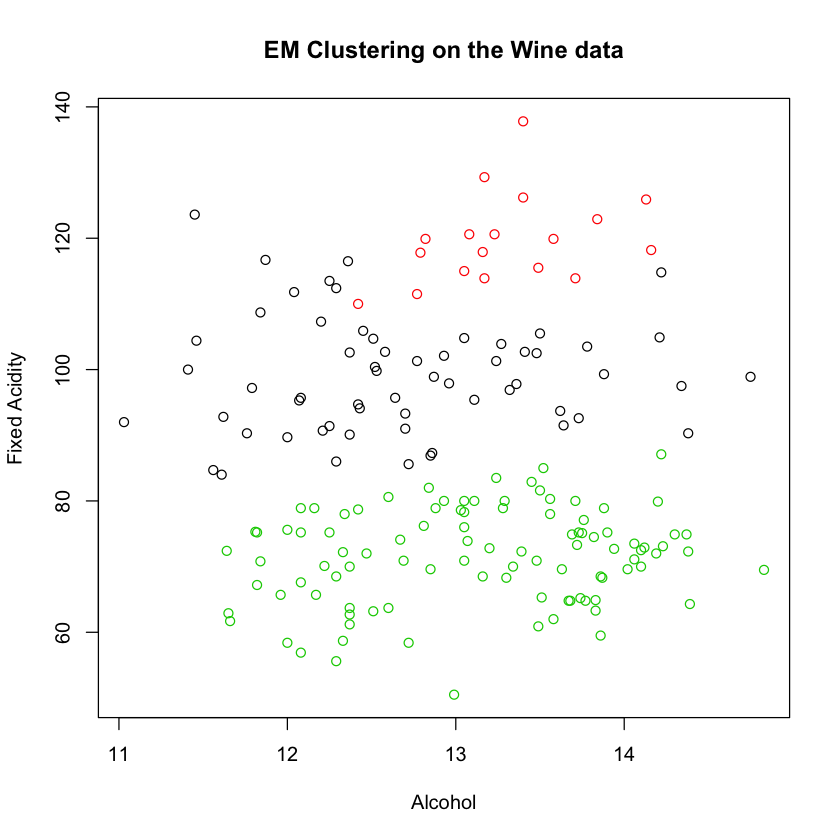

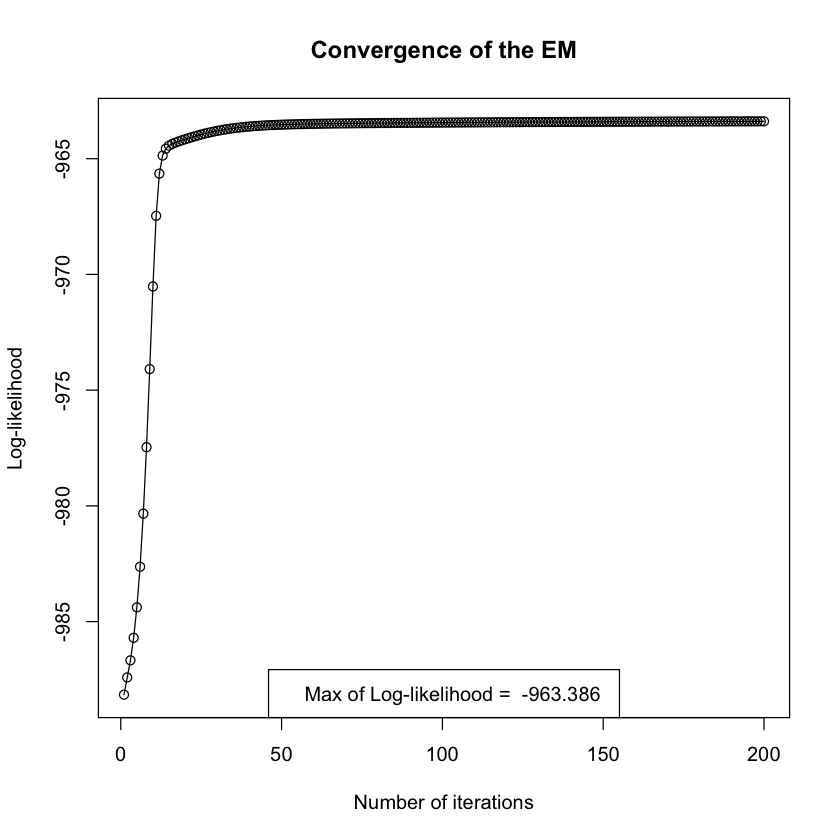

In [10]:
out = multivariate_EM(X, 3, 'random', 200)

#Visualisation 

probas = out[[4]]
logliks = out[[5]]
max_loglik = out[[6]]

cls = max.col(probas)
plot(X, col=cls, main= "EM Clustering on the Wine data")

plot(1:length(logliks), logliks, main = "Convergence of the EM",
     xlab = "Number of iterations", ylab = "Log-likelihood", type="o")
legend("bottom", paste("Max of Log-likelihood = ", round(max_loglik,3)))

***Remark***: *The covariance matrix $\Sigma$ needs to be invertible for the density $\mathcal{N}(x|\mu, \Sigma)$ to exist. It happens that the function log_gaussian_density returns an error for this reason. A solution to this problem could be to use a pseudo inverse, instead of the function solve used in mahalanobis*.

### Evaluation of the model

To evaluate the model we built, we can cluster the data and compare the results with the $k$-means algorithm. Two useful metrics for evaluation are the *Error Rate*,and the *Adjusted Rand Index*.

The *Error rate* computes the error rate of a given classification relative to the known classes and gives the location of misclassified data points. While the *Adjusted Rand Index* is a measure of the similarity between two data clusterings. It has zero expected value in the case of random partition, and it is bounded above by 1 in the case of perfect agreement between two partitions.

In our case, we are comparing the $EM$ clustering to the ground truth, and then comparing the $k$-means clustering to the ground truth, to see if one of the clusterings is more efficient than the other.

In [11]:
km = kmeans(X, centers=3)
km_y = km$cluster

paste("Adjusted Rand Index : ", round(adjustedRandIndex(km_y, y),3), ", Error rate : ", round(classError(km_y, y)$errorRate, 3))

[1] "Adjusted Rand Index :  0.149 , Error rate :  0.489"

The $EM$ allows to find local optima, therefore it is reasonable to try several different $EM$ with different initialization (random initializations in this case) and select the one for which the log-likelihood is maximized.

In [12]:
#Try 50 EM and keep the one with the highest likelihood
best_em = list()
max_loglik = -10000
for (i in 1:50){
    em = multivariate_EM(X, 3, 'random', 200)
    loglik = em[[6]]
    if (loglik > max_loglik){
        best_em = em
        max_loglik = loglik
    }
}

In [13]:
probas_ = best_em[[4]]
y_ = max.col(probas_)

paste("Adjusted Rand Index : ", round(adjustedRandIndex(y_, y),3), ", Error rate : ", round(classError(y_, y)$errorRate, 3))

[1] "Adjusted Rand Index :  0.329 , Error rate :  0.298"

Finally, the $EM$ with the highest training likelihood has an *Error rate* of $29$% and an *Adjusted Rand Index* of $0.329$, while the $k$-means algorithm has an *Error rate* of $49$% and an *Adjusted Rand Index* of $0.149$. 

The use of the $EM$ algorithm for Gaussian Mixture Models seems to be relevant and rather efficient in this case.

# Model selection

### Penalized model selection

An important problem in clustering is model selection. The goal is to choose the number of clusters $K$, and each number of clusters corresponds to a model $\mathcal{M_k} = (p_\theta, \theta \in \Theta_k)$. A first important set of techniques is the maximization of a penalized likelihood criterion:

$$\cal{L}(\mathcal{M_k}) = \sum_{i=1}^{n} log p(x_i) - penalty(\mathcal{M_k})$$


The motivation behind penalization is to discourage overly complex models and avoid overfitting. One way to formalize this is by counting the number of free parameters $q_k = dim(\Theta_k)$. This leads to two famous penalties:
- $\textrm{penalty}_{AIC} = q_k$
- $\textrm{penalty}_{BIC} = q_k log(n)/2$

In our case:
$$\begin{align}
q_k &= dim(\pi_1, ...,\pi_k) + \sum_{i=1}^{k}dim(\mu_1, ...,\mu_k) + \sum_{i=1}^{k} dim(\Sigma_1, ...,\Sigma_k)\\
&= (k-1) + k\times d + k \times \frac{d(d+1)}{2}
\end{align}$$

Where $d$ is the number of features of our data.

In [14]:
model_selection_AIC_BIC <- function(X, K){
    n = dim(X)[1]
    d = dim(X)[2]
    
    aics = c()
    bics = c()
    
    for (k in K){
        em = multivariate_EM(X, k, 'kmeans')
        loglik = em[[6]]
        q = (k-1) + k*d + k*(d*(d+1)/2)
        
        aics = append(aics, (loglik - q))
        bics = append(bics, (loglik - q*log(n)/2))
    }
    list(aics, bics)
}

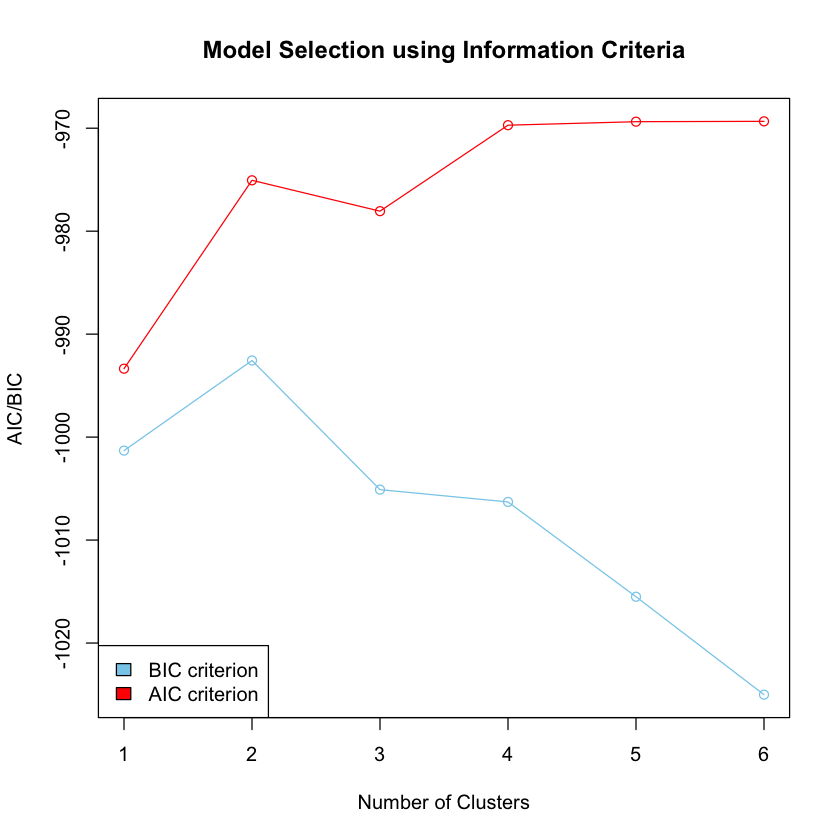

In [15]:
k_= c(1,2,3,4,5,6)
selection = model_selection_AIC_BIC(X, k_)
aic_ = selection[[1]]
bic_ = selection[[2]]

plot(k_, aic_, main= "Model Selection using Information Criteria", 
     ylim = c(min(min(aic_), min(bic_)), max(max(aic_), max(bic_))), xlab = "Number of Clusters", ylab = "AIC/BIC",
    type = "o", col = 'red')
lines(k_, bic_, col = 'skyblue')
points(k_, bic_, pch=1, col = 'skyblue')
legend("bottomleft", c("BIC criterion","AIC criterion"),fill=c("skyblue","red"))

The $AIC$ penalized likelihood is often at its maximum for $k=5$ or $k=6$. Although the $AIC$ varies a lot at each launch of the $EM$, while the $BIC$ criterion suggests rather consistently that the best number of clusters is $k=2$. 

The two criteria rarely seem to agree between them, and it is hard to choose a relevant number of clusters. The $AIC$ and the $BIC$ might not be very reliable for model selection in Gaussian Mixture Models. 

### Cross validation

Another solution is the use of $v$-fold cross-validation to analyze the number of clusters. In this process, we partition the data in $v$ equals parts, and each of the parts is then set aside at turn as validation set while a clustering is performed on the other $v-1$ subsets. At each iteration, the outcome of the clustering is used to compute the likelihood on the validation set. 

These $v$ values are then averaged for each alternative number of clusters we try, and finally, we select the number of clusters $k$ for which the average validation likelihood is the largest.

In [16]:
model_selection_CV <- function(X, K, v){
    #Validated likelihoods
    val_loglik = matrix(NA, nrow = v, ncol = length(K))
    
    #Random shuffle data and cut in v equals subsets
    X = X[sample(nrow(X)),]
    folds = cut(seq(1,nrow(X)),breaks=v,labels=FALSE)
    
    #For each validation subset
    for(i in 1:v){
        validInd <- which(folds==i,arr.ind=TRUE)
        validData <- X[validInd, ]
        trainData <- X[-validInd, ]
        
        acc = 0
        
        for (k in K){
            em = multivariate_EM(trainData, k, 'random')
            pis = em[[1]]; mus = em[[2]]; sigmas = em[[3]]

            #Computation of the validation log-likelihood
            n = dim(validData)
            sk = matrix(NA, nrow = n, ncol = k)
            for (kk in 1:k){
                sk[,kk] = log(pis[kk]) + log_gaussian_density(validData, mus[kk,],sigmas[[kk]]) 
            }
            
            acc = acc + 1
            val_loglik[i, acc] = sum(apply(sk, 1, logsumexp))            
        }
    }
    return(colMeans(val_loglik))
}

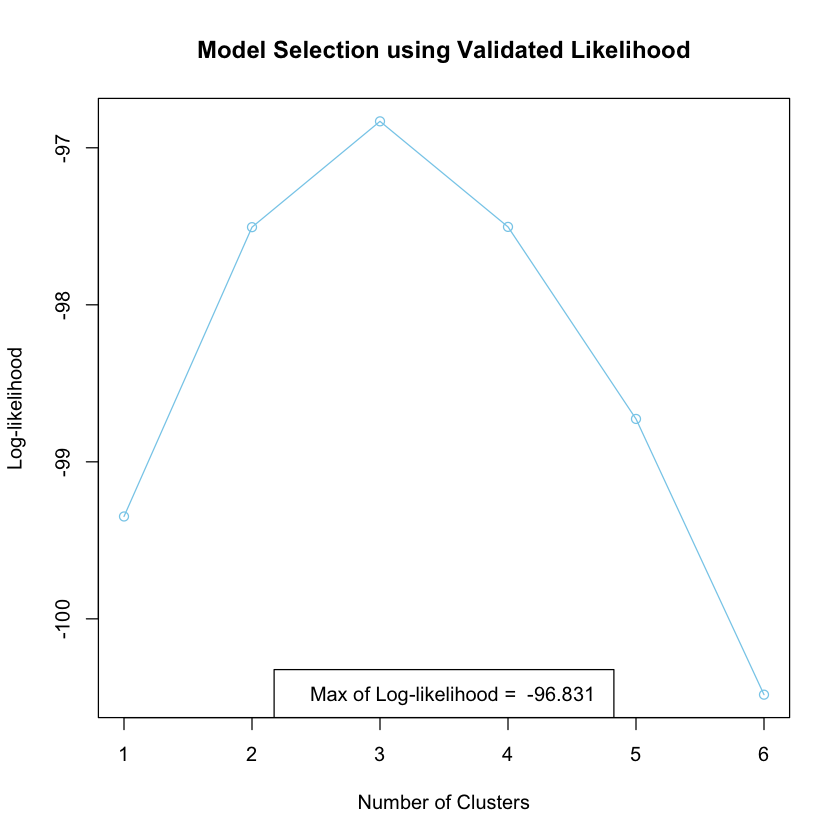

In [19]:
k_= c(1,2,3,4,5,6)
selection = model_selection_CV(X, k_, 10)
plot(k_, selection, main= "Model Selection using Validated Likelihood", 
     xlab='Number of Clusters', ylab='Log-likelihood',type = "o", col="skyblue")
legend("bottom", paste("Max of Log-likelihood = ", round(max(selection),3)))

This technique suggests that the best number of clusters would be $k=3$. 

Cross-validation seems to be more reliable than $AIC$ or $BIC$ as a model selection technique in this context. Indeed, the selected number of clusters seems to be rather consistent through the re-runs of the algorithm (almost always 3), and the fact that it relies on averaged values allows to mitigate the random aspect of the $EM$ algorithm.

# Towards higher dimensional spaces

Let us try to model more than just two variables of the wine dataset. 

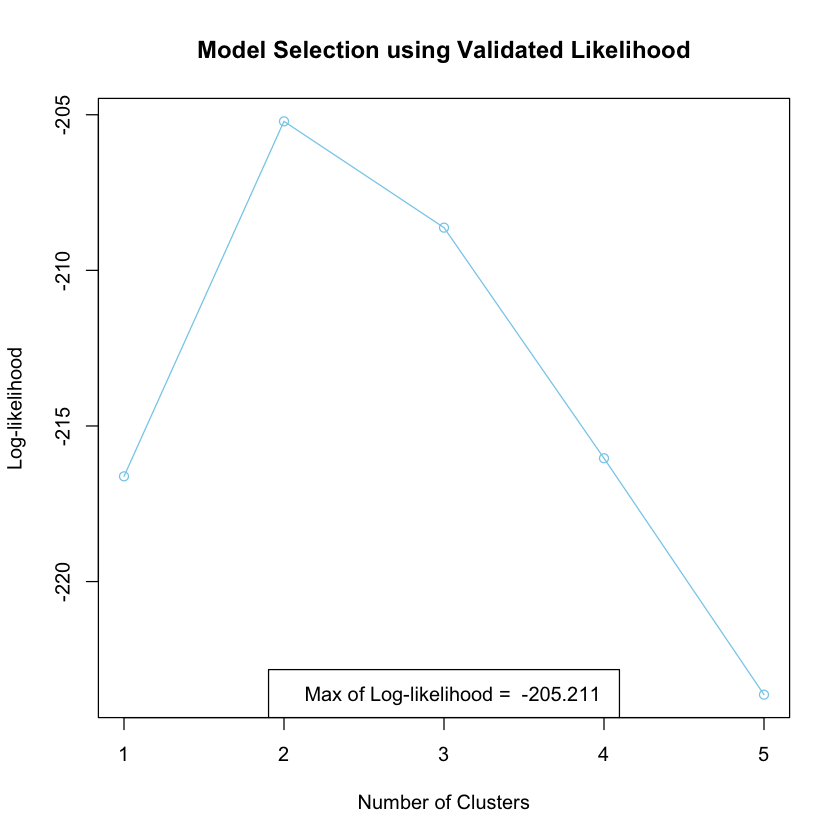

In [20]:
X_high = as.matrix(wine[,c(2,4,6,8)]) #Hard to try more than 4 because of the solve(cov,...) problem
k_high= c(1,2,3,4,5)

selection = model_selection_CV(X_high, k_high, 5)
plot(k_high, selection, main= "Model Selection using Validated Likelihood", 
     xlab='Number of Clusters', ylab='Log-likelihood',type = "o", col="skyblue")
legend("bottom", paste("Max of Log-likelihood = ", round(max(selection),3)))

In a higher dimensional space the cross validation seems to suggest the best number of clusters would be $k=2$.

In [25]:
#The whole dataset
X_high = as.matrix(wine[,-1])

#Try 50/100 EM with random initialization and keep the one with the highest likelihood
out_high = list()
max_loglik = -10000000
for (i in 1:50){
    em = multivariate_EM(X_high, 3, 'random', 500)
    loglik = em[[6]]
    if (loglik > max_loglik){
        out_high = em
        max_loglik = loglik
    }
}

probas_high = out_high[[4]]
y_high = max.col(probas_high)

paste("Adjusted Random Index : ", round(adjustedRandIndex(y_high, y),3), ", Error rate : ", round(classError(y_high, y)$errorRate, 3))

[1] "Adjusted Random Index :  0.052 , Error rate :  0.517"

In [26]:
#Only a few more variables
X_high = as.matrix(wine[,c(2,4,6,8)])

#Try 50/100 EM with random initialization and keep the one with the highest likelihood
out_high = list()
max_loglik = -10000000
for (i in 1:50){
    em = multivariate_EM(X_high, 3, 'random', 500)
    loglik = em[[6]]
    if (loglik > max_loglik){
        out_high = em
        max_loglik = loglik
    }
}

probas_high = out_high[[4]]
y_high = max.col(probas_high)

paste("Adjusted Random Index : ", round(adjustedRandIndex(y_high, y),3), ", Error rate : ", round(classError(y_high, y)$errorRate, 3))

[1] "Adjusted Random Index :  0.416 , Error rate :  0.236"

In [27]:
km_high = kmeans(X_high, centers=3)
km_y_high = km_high$cluster

paste("Adjusted Random Index : ", round(adjustedRandIndex(km_y_high, y),3), ", Error rate : ", round(classError(km_y_high, y)$errorRate, 3))

[1] "Adjusted Random Index :  0.149 , Error rate :  0.489"

We could expect that increasing the dimension of the space would give us better results as the number of potentially significative variables increases. 

On one hand for the $k$-means, the clustering does not seem to change a lot when we add variables, as the *Error rate* is exactly the same: $49$%. On the other hand for the $EM$, depending on the runs, the *Error rate* ranges from $21$% to $51$%. But it is hard to tell wether this variation is due to the random aspect of the algorithm (and in particular of the initialization) or not. 

In reality, it looks like the addition of a few variables does indeed improve the model. However, the $EM$ does not really seem suited for high dimensionnal datasets, as it yields bad results when using the whole dataset.